In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [10]:
%cd  /gdrive/My\ Drive/Colab\ Notebooks/FARS
!pwd

/gdrive/My Drive/Colab Notebooks/FARS
/gdrive/My Drive/Colab Notebooks/FARS


In [2]:
import pandas as pd
import requests
import zipfile
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
import numpy as np

In [3]:
def download_all_data():
  year = 1975
  while year <=2020:

    if (not os.path.exists(str(year))):
        os.mkdir(str(year))

    url = f"https://static.nhtsa.gov/nhtsa/downloads/FARS/{year}/National/FARS{year}NationalCSV.zip"

    r = requests.get(url)

    if r.status_code == 200:
        zipf = f"{year}/{url.split('/')[-1]}"

        with open(zipf, "wb") as fo:
            fo.write(r.content)

            # unzip
            zipfile.ZipFile(zipf).extractall(str(year)) 
    year = year + 1
download_all_data()

In [11]:
def get_all_years_accident_df():
  accidents_df = None
  year = 1975
  while year <=2020:
    file_paths = [os.path.join("./", str(year), "ACCIDENT.CSV") ,
                  os.path.join("./", str(year), "ACCIDENT.csv"),
                  os.path.join("./", str(year), "accident.CSV"),
                  os.path.join("./", str(year), "accident.csv")]
    for file_path in file_paths:
      if os.path.exists(file_path):
        df = pd.read_csv(file_path, encoding="ISO-8859-1")
        break
    if accidents_df is None:
      accidents_df = df
    else: 
      accidents_df = accidents_df.append(df)
    year = year + 1
  return accidents_df
all_years_accidents_df = get_all_years_accident_df()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DtypeWarning: Columns (40,42) have mixed types.Specify dtype option on import or set low_memory=False.


In [12]:
#• you are using data from the 1975-2020 that you found in HW1
#• you are including all states data except Kansas
#• restrict to numeric features, eliminate year as a feature
#• scale the data using scikit-learn Standard Scaler

In [13]:
accidents_train_df = all_years_accidents_df[all_years_accidents_df['STATENAME']  != 'Kansas']
accidents_test_df = all_years_accidents_df[all_years_accidents_df['STATENAME']  == 'Kansas']

In [14]:
accidents_train_df = accidents_train_df[['STATE','MONTH','DAY','HOUR','PERSONS','MAN_COLL','LGT_COND','WEATHER','SCH_BUS','FATALS','DAY_WEEK','DRUNK_DR']]
accidents_train_df.dropna()
#accidents_train_df = accidents_train_df.head(1000)
accidents_train_df.head()

,STATE,MONTH,DAY,HOUR,PERSONS,MAN_COLL,LGT_COND,WEATHER,SCH_BUS,FATALS,DAY_WEEK,DRUNK_DR
0,1,1,4,22,3,2,2,1,NaN,1,7,0
1,1,1,2,4,2,0,2,1,NaN,1,5,0
2,1,1,1,4,1,0,2,1,NaN,1,4,0
3,1,1,2,14,3,0,1,1,NaN,1,5,0
4,1,1,5,20,1,0,2,1,NaN,1,1,0


In [15]:
accidents_test_df = accidents_test_df[['STATE','MONTH','DAY','HOUR','PERSONS','MAN_COLL','LGT_COND','WEATHER','SCH_BUS','FATALS','DAY_WEEK','DRUNK_DR']]
accidents_test_df.dropna()
#accidents_test_df = accidents_test_df.head(1000)
accidents_test_df.head()

,STATE,MONTH,DAY,HOUR,PERSONS,MAN_COLL,LGT_COND,WEATHER,SCH_BUS,FATALS,DAY_WEEK,DRUNK_DR
12442,20,1,1,16,3,8,1,2,0.0,1,5,0
12443,20,1,9,99,2,0,3,1,0.0,2,6,0
12444,20,1,10,17,1,0,5,1,0.0,1,7,0
12445,20,1,11,22,4,1,3,1,0.0,1,1,1
12446,20,1,14,0,2,2,2,1,0.0,1,4,1


In [16]:
sc = StandardScaler()
accidents_train_df = accidents_train_df.dropna()
accidents_test_df = accidents_test_df.dropna()

sc.fit(accidents_train_df)
X_train_std = sc.transform(accidents_train_df)
X_test_std = sc.transform(accidents_test_df)
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.fit_transform(X_test_std) 

In [17]:
def plot_clusters(X_test_pca, model, clusters):
  y_kmeans = model.fit_predict(X_test_pca)
  #6 Visualising the clusters
  for cluster in range(clusters):
    plt.scatter(X_test_pca[y_kmeans==0, 0], X_test_pca[y_kmeans==0, 1], s=100, c='red', label ='Cluster ' + str(cluster))

  plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')
  plt.title('Clusters of Customers')
  plt.show()

# Perform ad hoc K-Means clustering

In [18]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

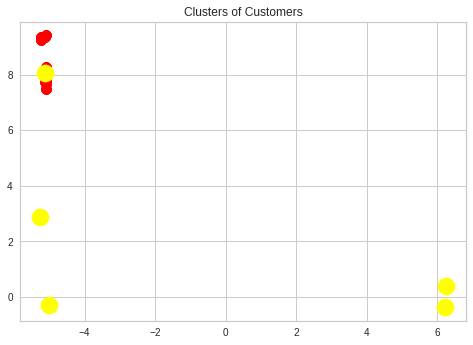

In [19]:
kmeanModel_5 = KMeans(n_clusters=5,
                    init='k-means++',
                    max_iter=200,
                    n_init=10, 
                    random_state=0)
kmeanModel_5 = kmeanModel_5.fit(X_train_pca)
kmeanModel_5.cluster_centers_
plot_clusters(X_test_pca, kmeanModel_5, 5)

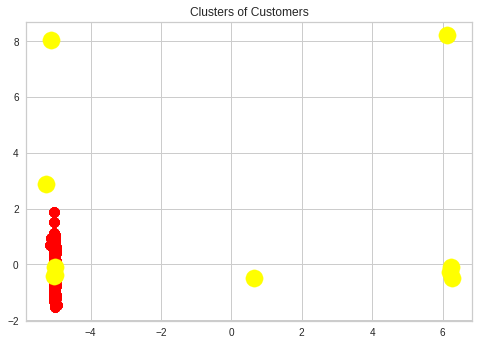

In [20]:
kmeanModel_10 = KMeans(n_clusters=10,
                    init='k-means++',
                    max_iter=200,
                    n_init=10, 
                    random_state=0)
kmeanModel_10 = kmeanModel_10.fit(X_train_pca)
kmeanModel_10.cluster_centers_
plot_clusters(X_test_pca, kmeanModel_10, 10)

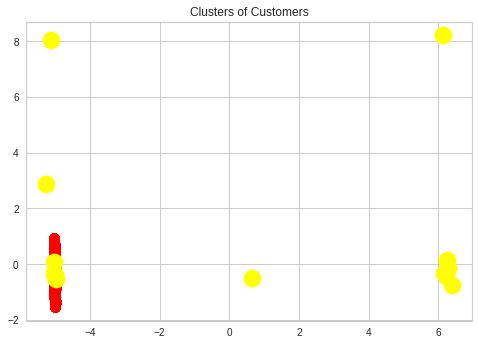

In [21]:
kmeanModel_15 = KMeans(n_clusters=15,
                    init='k-means++',
                    max_iter=200,
                    n_init=10, 
                    random_state=0)
kmeanModel_15 = kmeanModel_15.fit(X_train_pca)
kmeanModel_15.cluster_centers_
plot_clusters(X_test_pca, kmeanModel_15, 15)

# Perform elbow analysis to find optimal cluster size

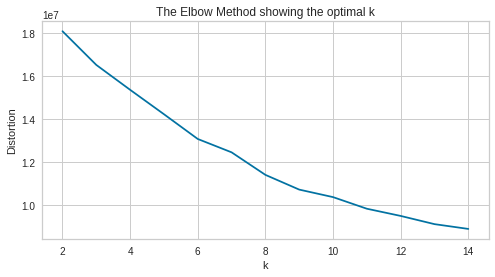

In [22]:
distortions = []
K = range(2,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k,
                        init = 'k-means++',
                        max_iter=200,
                        n_init=10, 
                        random_state=0)
    kmeanModel.fit(X_train_pca)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(8,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [23]:
#• the optimal 𝐾
#• the reanalysis of the previous answer based on the optimal 𝐾 (re-run your clusters and report their centroid characteristics)

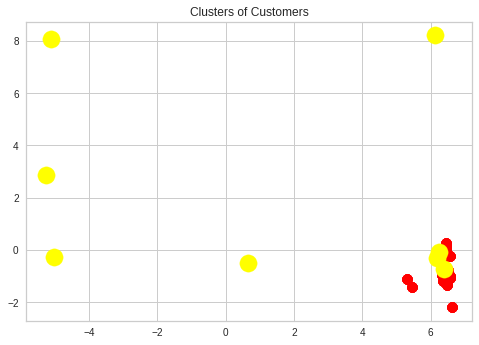

In [24]:
kmeanModel = KMeans(n_clusters=8,
                    init='k-means++',
                    max_iter=200,
                    n_init=10, 
                    random_state=0)
kmeanModel = kmeanModel.fit(X_train_pca)
plot_clusters(X_test_pca, kmeanModel, 8)

# Perform Agglomorative Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=8).fit(X_train_pca)

In [ ]:
plot_clusters(X_test_pca, clustering, 8)

# Find out where Kansas fits in

In [ ]:
kansas_preds_aglo = clustering.predict(X_test_pca)

In [ ]:
kansas_preds_kmean = kmeanModel.predict(X_test_pca)